TAREA:
Los ejemplos ilustrativos anteriores permiten conocer el número de monedas presentes en la imagen.

Se sugiere identificar de manera interactiva (por ejemplo, haciendo clic en la imagen) una moneda de valor conocido presente en la imagen (por ejemplo, de 1 €).
Después de obtener esta información y las dimensiones en milímetros de las distintas monedas, elabora una propuesta para estimar la cantidad de dinero presente en la imagen.
Muestra el recuento de monedas y el importe total directamente sobre la imagen.
No hay restricciones en el uso de medidas geométricas o de color.

Una vez resuelto el problema con la imagen ideal proporcionada, adquiere una o más imágenes que contengan monedas reales.
Aplica el mismo esquema: después de identificar la moneda de valor conocido, calcula la cantidad de dinero presente en la imagen.
¿Funciona correctamente?
¿Se observan problemas?

Nota:
Para establecer la correspondencia entre píxeles y milímetros, se señala que:

la moneda de 1 € tiene un diámetro de 23,25 mm,
la de 50 centavos de 24,35 mm,
la de 20 centavos de 22,25 mm, etc.

In [ ]:
import cv2             
import numpy as np        

IMG_PATH = "Monedas.jpg"

COIN_DIAM_MM = {       
    "2€": 25.75,           
    "1€": 22.2,             
    "50c": 24.35,     
    "20c": 22.25, 
    "10c": 19.75,      
    "5c": 21.25,  
    "2c": 18.75,        
    "1c": 16.25,   
}

MM_TOL = 1.0 # Tolerancia (en mm) para decidir si un diámetro estimado “coincide” con un tipo de moneda

#funciones

def detect_circles(img_bgr):
#Encuentra círculos con HoughCircles
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY) 
    blur = cv2.medianBlur(gray, 7) # Aplica un filtro mediano (reduce ruido)
    circ = cv2.HoughCircles( # Detecta círculos con la transformada de Hough
        blur, cv2.HOUGH_GRADIENT, # Método de Hough (gradiente)
        dp=1, # Relación resolución acumulador/imagen si es 1 = igual 
        minDist=100, # Distancia mínima entre centros de círculos
        param1=100, # Umbral alto para Canny 
        param2=50, # Umbral del acumulador Hough; si es más alto hay menos falsos positivos
        minRadius=40, # Radio mínimo en píxeles de los círculos buscados
        maxRadius=200 # Radio máximo ...
    )
    if circ is None: # Si no se han encontrado círculos
        return [] # Devuelve lista vacía
    return [(int(x), int(y), int(r)) for (x, y, r) in circ[0]]  # Convierte los resultados en enteros (x, y, r)

def estimate_scale_mm_per_px(circles):
    
    # Estima mm/px de forma elemental: para cada círculo (r) y para cada moneda (diámetro D), calcula s = D / (2*r). Toma la mediana de todas las s.
    
    s_list = [] # Lista de hipótesis de escala (mm/px)
    for (_, _, r) in circles: # Recorre todos los círculos encontrados
        if r <= 0: # Si el radio no es válido
            continue # Salta
        for D in COIN_DIAM_MM.values(): # Prueba cada diámetro nominal
            s = D / (2.0 * r) # Escala hipotética: mm/px = diámetro / (2 * radio)
            if 0.01 < s < 2.0: # Filtro simple para excluir valores absurdos
                 s_list.append(s) # Añade la hipótesis
    if not s_list: # Si no hay hipótesis
        return None # Devuelve None (fallo)
    return float(np.median(np.array(s_list, dtype=np.float32))) # Devuelve la mediana de las escalas

def nearest_coin_by_diameter(diam_mm):
#Encuentra la moneda con el diámetro nominal más cercano a diam_mm

    best_name, best_err = None, 1e9 # Inicializa el mejor nombre y error mínimo; 1e9 sería 1x10^9, un número enorme cualquiera
    for name, D in COIN_DIAM_MM.items(): # Recorre todas las monedas conocidas
        err = abs(D - diam_mm) # Error absoluto entre el diámetro estimado y el nominal
        if err < best_err: # Si es el error más pequeño visto hasta ahora
            best_name, best_err = name, err # Actualiza el mejor
    if best_err > MM_TOL: # Si el error supera la tolerancia
        return None, best_err # Considera el reconocimiento incierto (None)
    return best_name, best_err # Devuelve el mejor nombre y el error

def coin_value_eur(name):
#Convierte '2€', '50c'... en valor en euros (float)
    if not name: # Si el nombre es None o cadena vacía
        return 0.0 # Valor cero
    if name.endswith("€"): # Si la cadena termina con el símbolo del euro
        return float(name[:-1]) # Convierte la parte numérica en float (ej. "2€" -> 2.0)
    else: # De lo contrario es en céntimos (ej. "50c")
        return float(name[:-1]) / 100.0 # Convierte la parte numérica y divide por 100 (50 -> 0.5)

def pick_nearest_circle(circles, x, y):
#Devuelve el índice del círculo más cercano al clic
    best_i, best_d2 = -1, 1e18 # Inicializa el mejor índice y 1e18 sería 1x10^18, un número enorme cualquiera
    for i, (cx, cy, r) in enumerate(circles): # Recorre todos los círculos
        d2 = (cx - x)**2 + (cy - y)**2 # Distancia al cuadrado entre el clic y el centro del círculo
        if d2 < best_d2: # Si esta es la distancia mínima encontrada
            best_i, best_d2 = i, d2 # Actualiza el índice del círculo más cercano
    return best_i # Devuelve el índice (o -1 si no se encuentra)

# Aquí cargamos la imagen y encuentra el valor

img = cv2.imread(IMG_PATH) 
if img is None:                                     
    raise FileNotFoundError(f"Imagen no encontrada: {IMG_PATH}") 

circles = detect_circles(img) # Detecta los círculos en la imagen
if not circles: # Si la lista está vacía
    raise SystemExit("No se encontraron círculos. Modifica los parámetros de HoughCircles (min/maxRadius, param2...).")

# Aquí hay una estimación para la escala

s_mm_per_px = estimate_scale_mm_per_px(circles) # Estima la escala global (mm/px)
if s_mm_per_px is None: # Si no fue posible estimar la escala
    raise SystemExit("Imposible estimar la escala (mm/px).")         

# Pre-cálculo y para cada círculo, el nombre de la moneda más cercano

assignments = [] # Lista que contendrá (nombre_moneda, diámetro_estimado_mm) para cada círculo
for (x, y, r) in circles: # Recorre todos los círculos detectados
    diam_est = 2.0 * s_mm_per_px * r # Estima el diámetro en mm: 2 * escala * radio
    name, err = nearest_coin_by_diameter(diam_est) # Encuentra la moneda más cercana a este diámetro
    assignments.append((name, diam_est)) # Guarda el resultado en la misma posición del círculo

# Interfaz para el clic

disp = img.copy() # Crea una copia de la imagen para dibujar superposiciones

for (x, y, r) in circles: # Dibuja todos los círculos encontrados
    cv2.circle(disp, (x, y), r, (0, 255, 0), 2) # Contorno verde para cada moneda

state_total = 0.0 # Total en euros de las monedas clicadas
clicked_indices = set() # Conjunto de índices ya clicados (evita doble conteo)

def on_mouse(event, x, y, flags, param): # Callback ejecutada en cada evento del ratón
    global state_total # Indica que usaremos la variable global state_total
    if event != cv2.EVENT_LBUTTONDOWN: # Procede solo si se presiona el botón izquierdo
        return

    idx = pick_nearest_circle(circles, x, y) # Encuentra el círculo más cercano al punto clicado
    if idx < 0: # Si no hay ningún círculo válido
        return

    cx, cy, r = circles[idx] # Extrae centro y radio del círculo seleccionado
    name, diam_est = assignments[idx] # Recupera el nombre estimado y el diámetro estimado para ese círculo

    cv2.circle(disp, (cx, cy), r, (0, 0, 255), 3) # Resalta la moneda clicada con un contorno rojo
    label = name if name else "?" # Si no se reconoce dentro de la tolerancia, muestra "?"
    text = f"{label} ({diam_est:.1f} mm)" # Texto a visualizar: nombre y diámetro estimado
    cv2.putText( # Dibuja el texto cerca de la moneda
        disp, text, (max(5, cx - r), max(20, cy - r - 10)),
        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2, cv2.LINE_AA
    )

    if idx not in clicked_indices and name: # Si es la primera vez que se hace clic en esta moneda y tiene un nombre válido
        clicked_indices.add(idx) # Marca el índice como ya contado
        state_total += coin_value_eur(name) # Añade el valor de la moneda al total

    h, w = disp.shape[:2]  # Altura y anchura de la imagen

    # Cuadro blanco en la parte inferior
    cv2.rectangle(disp, (10, h - 50), (360, h - 15), (255, 255, 255), -1)

    # Texto encima del cuadro
    cv2.putText(
        disp, f"Total clicado: {state_total:.2f} euros", (15, h - 25),
        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (50, 120, 50), 2, cv2.LINE_AA
    )


win = "Haz clic en las monedas (q para salir)" # Nombre de la ventana principal
cv2.namedWindow(win) # Crea la ventana
cv2.setMouseCallback(win, on_mouse) # Registra el callback para manejar los clics del ratón

try:
    while True: # Bucle principal de la GUI OpenCV
        cv2.imshow(win, disp) # Muestra la imagen con las superposiciones
        k = cv2.waitKey(20) & 0xFF # Espera 20 ms y lee una posible tecla presionada
        if k in (ord('q'), 27):                       
            break                                    
        if cv2.getWindowProperty(win, cv2.WND_PROP_VISIBLE) < 1: # Si la ventana se ha cerrado con la X
            break                                  
finally:
    cv2.destroyAllWindows()                   
    cv2.waitKey(1)  


TAREA: La tarea consiste en extraer características (geométricas y/o visuales) de las tres imágenes completas de partida, y *aprender* patrones que permitan identificar las partículas en nuevas imágenes. Para ello se proporciona como imagen de test *MPs_test.jpg* y sus correpondientes anotaciones *MPs_test_bbs.csv* con la que deben obtener las métricas para su propuesta de clasificación de microplásticos, además de la matriz de confusión. La matriz de confusión permitirá mostrar para cada clase el número de muestras que se clasifican correctamente de dicha clase, y el número de muestras que se clasifican incorrectamente como perteneciente a una de las otras dos clases.

En el trabajo [SMACC: A System for Microplastics Automatic Counting and Classification](https://doi.org/10.1109/ACCESS.2020.2970498), las características geométricas utilizadas fueron:

- Área en píxeles
- Perímetro en píxeles
- Compacidad (relación entre el cuadrado del perímetro y el área de la partícula)
- Relación del área de la partícula con la del contenedor
- Relación del ancho y el alto del contenedor
- Relación entre los ejes de la elipse ajustada
- Definido el centroide, relación entre las distancias menor y mayor al contorno

Perfiles Medios (Centroides) por Clase
              0           1          2         3         4         5         6
FRA  693.704082  155.180264  46.607475  0.590655  1.015227  1.925587  0.306110
PEL  303.897059   89.253486  35.176795  0.640866  0.922107  1.589901  0.436401
TAR  364.892857   77.321907  23.944741  0.625681  1.174663  1.752527  0.492679
Resultados de la Clasificación
Accuracy: 0.49
Precision (weighted): 0.64


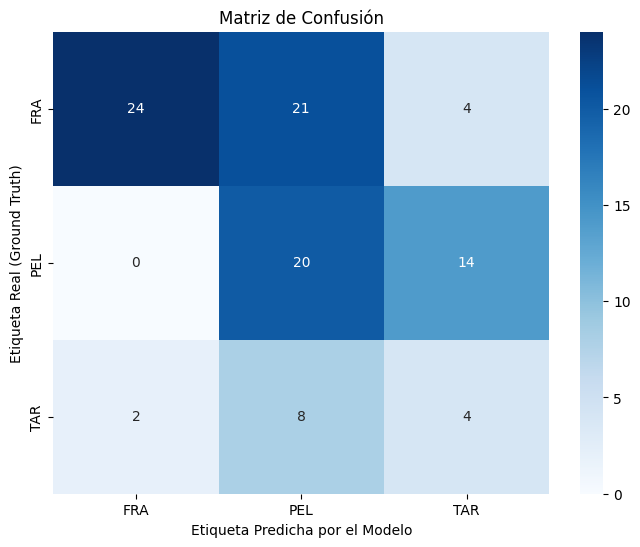

In [ ]:
import cv2 
import numpy as np  
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns  #
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score  # Métricas de evaluación
from scipy.spatial import distance  # Distancias (euclídea) para comparar con los centroides

# Características de la imagen 

def estrai_caratteristiche(immagine_particella):  # Define la función que extrae las 7 características de una sola partícula

#Dada una pequeña imagen que contiene una partícula, la segmenta y calcula las 7 características geométricas requeridas.
 
    # Para la segmentación, usamos un umbral simple de Otsu
    # Convertimos a escala de grises
    gray = cv2.cvtColor(immagine_particella, cv2.COLOR_BGR2GRAY)
    # Aplicamos un umbral inverso (las partículas son oscuras sobre un fondo claro)
    _, imbin = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)  # Binariza con Otsu e inversión

    # Encontramos los contornos. Esperamos que el más grande sea nuestra partícula
    contours, _ = cv2.findContours(imbin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)  # Extrae los contornos externos

    # Si no se encuentra ningún contorno, no podemos calcular nada
    if not contours: 
        return None

    # Seleccionamos el contorno con el área más grande
    c = max(contours, key=cv2.contourArea)  # Toma el contorno con el área máxima
    area = cv2.contourArea(c)  # Calcula el área del contorno seleccionado

    # Ignoramos partículas demasiado pequeñas que podrían ser solo ruido
    if area < 10:  # Filtra objetos demasiado pequeños
        return None  # Descarta esta partícula

    # Aquí calculamos las 7 características 
    # punto 0
    perimetro = cv2.arcLength(c, True)  # Calcula el perímetro

    # Área en píxeles, punto 1
    feat_area = area  # Asigna el área a la característica 1

    # Perímetro en píxeles, punto 2
    feat_perimetro = perimetro  # Asigna el perímetro a la característica 2

    # Compacidad (Perímetro^2 / Área), punto 3 
    feat_compattezza = (perimetro ** 2) / area if area > 0 else 0  # Evita la división por cero

    # Relación área partícula / área contenedor, punto 4
    x, y, w, h = cv2.boundingRect(c)  # Obtiene la bounding box alineada a los ejes
    area_contenitore = w * h  # Área del bounding box
    feat_rapporto_area_contenitore = area / area_contenitore if area_contenitore > 0 else 0  # Relación de área

    # Relación ancho / alto del contenedor, punto 5
    feat_aspect_ratio = w / h if h > 0 else 0  # Evita la división por cero

    # Relación entre los ejes de la elipse ajustada, punto 6
    # cv2.fitEllipse requiere al menos 5 puntos en el contorno
    if len(c) >= 5:  # Verifica número suficiente de puntos para fitEllipse
        (center, axes, orientation) = cv2.fitEllipse(c)  # Ajusta una elipse al contorno
        major_axis, minor_axis = max(axes), min(axes)  # Extrae eje mayor y menor
        feat_rapporto_ellisse = major_axis / minor_axis if minor_axis > 0 else 0  # Relación de ejes
    else:
        feat_rapporto_ellisse = 0 # Valor por defecto si no es calculable

    # Relación distancias min/max desde el centroide al contorno, punto 7
    M = cv2.moments(c)  # Calcula los momentos para obtener el centroide
    # Evitamos la división por cero
    if M["m00"] == 0: return None  # Si el área del momento es nula, interrumpe (evita división por cero)
    cx = int(M["m10"] / M["m00"])  # Coordenada x del centroide
    cy = int(M["m01"] / M["m00"])  # Coordenada y del centroide
    
    # Calculamos la distancia de cada punto del contorno al centroide
    distanze = [np.sqrt((p[0][0] - cx)**2 + (p[0][1] - cy)**2) for p in c]  # Distancias punto-centroide
    dist_max, dist_min = max(distanze), min(distanze)  # Extrae distancia máxima y mínima
    feat_rapporto_dist_centroide = dist_min / dist_max if dist_max > 0 else 0  # Relación min/max

    # Devolvemos una lista con las 7 características calculadas
    return [ 
        feat_area, feat_perimetro, feat_compattezza, feat_rapporto_area_contenitore,
        feat_aspect_ratio, feat_rapporto_ellisse, feat_rapporto_dist_centroide
    ]

# Script principal

# Carga la imagen y las anotaciones CSV
img_originale = cv2.imread('MPs_test.jpg') 
annotazioni = pd.read_csv('MPs_test_bbs.csv')

lista_caratteristiche = []  # Acumula los vectores de características
etichette_reali = []  # Acumula las etiquetas ground truth

# Itera sobre cada fila del CSV (cada partícula anotada)
for index, row in annotazioni.iterrows():  # Bucle sobre cada anotación
    # Recorta la partícula de la imagen principal usando las coordenadas
    x_min, y_min = int(row['x_min']), int(row['y_min'])  # Convierte coordenadas mínimas a int
    x_max, y_max = int(row['x_max']), int(row['y_max'])  # Convierte coordenadas máximas a int
    immagine_particella = img_originale[y_min:y_max, x_min:x_max]  # Recorta la partícula

    # Extrae las características de la partícula recortada
    caratteristiche = estrai_caratteristiche(immagine_particella)  # Calcula las 7 características
    
    # Añade los resultados a nuestras listas solo si la extracción tuvo éxito
    if caratteristiche:  
        lista_caratteristiche.append(caratteristiche)  # Añade el vector de características
        etichette_reali.append(row['label'])  # Añade la etiqueta correspondiente

# "Aprendizaje" mediante cálculo de centroides

# Creamos un DataFrame para calcular fácilmente los promedios
df_features = pd.DataFrame(lista_caratteristiche)  # DataFrame de las características
df_features['label'] = etichette_reali  # Columna con la etiqueta

# Calculamos el perfil medio (centroide) para cada clase
centroidi = df_features.groupby('label').mean().to_dict('index')  # Promedios por clase 
nomi_classi = list(centroidi.keys())  # Lista ordenada de las clases presentes

print("Perfiles Medios (Centroides) por Clase") 
print(pd.DataFrame(centroidi).T)  # Muestra los promedios por clase (transpuesto para legibilidad)

# Clasificación basada en los centroides
etichette_predette = []  # Lista de etiquetas predichas

# Clasificamos cada partícula
for features in lista_caratteristiche:  # Para cada vector de características
    # Calculamos la distancia de la partícula a cada centroide de clase
    distanze = [distance.euclidean(features, list(centroidi[classe].values())) for classe in nomi_classi]  # Distancias a los centroides
    
    # La predicción es la clase con la distancia menor
    predizione = nomi_classi[np.argmin(distanze)]  # Índice de la distancia mínima → clase estimada
    etichette_predette.append(predizione)  # Añade la predicción a la lista

# Evaluación del rendimiento

print("Resultados de la Clasificación")  # Encabezado de resultados
print(f"Accuracy: {accuracy_score(etichette_reali, etichette_predette):.2f}")  # Muestra la precisión global
print(f"Precision (weighted): {precision_score(etichette_reali, etichette_predette, average='weighted'):.2f}")  # Precisión media ponderada

# Calcula y visualiza la Matriz de Confusión
conf_matrix = confusion_matrix(etichette_reali, etichette_predette, labels=nomi_classi)  # Matriz de confusión (filas=reales, columnas=predichas)

plt.figure(figsize=(8, 6))  # Ajusta el tamaño de la figura
sns.heatmap(  # Crea el mapa de calor de la matriz de confusión
    conf_matrix,
    annot=True, # Muestra los números dentro de las celdas
    fmt='d', # Formato entero
    cmap='Blues',
    xticklabels=nomi_classi,
    yticklabels=nomi_classi
)
plt.title('Matriz de Confusión') 
plt.ylabel('Etiqueta Real (Ground Truth)')  
plt.xlabel('Etiqueta Predicha por el Modelo') 
plt.show() 
